In [55]:
!pip install plotly
!pip install matplotlib_scalebar
!pip install adjustText

In [2]:
pip install seaborn 

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import os
import fiona
import folium
import requests
import matplotlib
import geopandas as gpd
import plotly.express as px
from pyproj import Transformer
from folium.plugins import Draw
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from folium.plugins import BeautifyIcon
from sklearn.cluster import MiniBatchKMeans
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.font_manager import FontProperties
from shapely.geometry import Point, LineString, Polygon
from math import floor
from scipy.spatial import KDTree
import math

/Users/kruthikaramesh/opt/anaconda3/envs/newenv/lib/python3.11/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.2-CAPI-1.17.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/var/folders/j_/yy54qztd2qv_yhxvrrgcbd1c0000gn/T/ipykernel_90477/2649238859.py:8: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups

In [4]:
from sklearn.metrics.pairwise import haversine_distances

In [5]:
def boundary_check(data,longitude,latitude):
    to_del = []
    long_del_east = data[data[longitude] > 0.4].index.to_list()
    long_del_west = data[data[longitude] <-0.5].index.to_list()
    lat_del_upper = data[data[latitude] >51.7].index.to_list()
    lat_del_lower = data[data[latitude] <51.2].index.to_list()

    to_del.extend(long_del_east)
    to_del.extend(long_del_west)
    to_del.extend(lat_del_upper)
    to_del.extend(lat_del_lower)
    to_del = set(to_del)
    return to_del

## Reading the dataset

### 1. Restaurant Data 

In [6]:
raw_restaurant_data = pd.read_csv("London Population /Cleaned_restaurants.csv")

In [7]:
nonnulll_raw_restaurant_data = raw_restaurant_data.dropna(subset=['Latitude','Longitude'])

In [8]:
print(f'Before deletion of rows: {len(nonnulll_raw_restaurant_data)}')
rest_del = boundary_check(nonnulll_raw_restaurant_data,'Longitude','Latitude')
nonnulll_raw_restaurant_data = nonnulll_raw_restaurant_data.drop(index=rest_del)
print(f'After deletion of rows: {len(nonnulll_raw_restaurant_data)}')

Before deletion of rows: 64323
After deletion of rows: 64287


In [9]:
# Define the string values
string_values = ['restaurant', 'Pub', 'Catering', 'Hotel','caterer','Takeaway','Farmers/growers','university']

# Create a new column
nonnulll_raw_restaurant_data['category_restaurant'] = nonnulll_raw_restaurant_data['Business Type'].str.contains('|'.join(string_values), case=False)

In [10]:
category_restaurant = nonnulll_raw_restaurant_data.loc[nonnulll_raw_restaurant_data.category_restaurant==True]

In [11]:
category_restaurant['Business Name '] = category_restaurant['Business Name '].astype(str)

/var/folders/j_/yy54qztd2qv_yhxvrrgcbd1c0000gn/T/ipykernel_90477/2999336237.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  category_restaurant['Business Name '] = category_restaurant['Business Name '].astype(str)


### Importing the final file 

In [12]:
cuisine_restaurants = pd.read_csv("Final_combining_Restaurants .csv")

In [13]:
import pandas as pd

# Assuming your first dataset is named 'df1' and the second dataset is named 'df2'

# Merge the two datasets based on 'Latitude' and 'Longitude', and keep only the desired column from the second dataset
merged_df = cuisine_restaurants.merge(nonnulll_raw_restaurant_data[['Latitude', 'Longitude', 'Post Code']], on=['Latitude', 'Longitude'], how='inner')




In [14]:
merged_df = merged_df.drop_duplicates(subset=['Address '], keep='first')

### Importing Post Code file

In [15]:
london_postcode = pd.read_csv('London Population /london_postcodes-ons-postcodes-directory-feb22.csv')

In [16]:
postcode_olsua = london_postcode[['pcds','oslaua']]

In [17]:
merged_data = pd.merge(merged_df, postcode_olsua, left_on='Post Code', right_on='pcds', how='inner')


In [18]:
nonna_merged_data = merged_data.dropna(subset = ['Latitude'])

### Data Preprocessing

We have noticed Rating value and hyginee columns containing NAN and Awaiting inspection values. For these rows we will perform numerical imputation using regression to predict the rating values based on the location. This is done instead of deleting the rows to prevent data loss. Imptuing with mean i not condisered as it can introduce bias. 

In [19]:
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression

# Select the 'Rating Value' column
rating_col = nonna_merged_data['Rating Value']

# Create a mask for rows with missing values
missing_mask = rating_col.eq('AwaitingPublication') | rating_col.eq('AwaitingInspection') | rating_col.eq('Exempt')

# Create a copy of the 'Rating Value' column for imputation
rating_imputed = rating_col.copy()

# Map the string values to NaN
rating_imputed[missing_mask] = np.nan

# Convert the 'Rating Value' column to float type
rating_imputed = rating_imputed.astype(float)

# Creating a regression imputer
imputer = IterativeImputer(estimator=LinearRegression(), random_state=0)

# Fit and transform the 'Rating Value' column with missing values
rating_imputed = imputer.fit_transform(rating_imputed.values.reshape(-1, 1))

# Flatten the imputed values
rating_imputed = rating_imputed.flatten()

# Assign the imputed values back to the original DataFrame
nonna_merged_data.loc[missing_mask, 'Rating Value'] = rating_imputed[:missing_mask.sum()]

# Save the modified DataFrame to a CSV file
nonna_merged_data.to_csv('new_rating_imputed_data.csv', index=False)


In [20]:
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression

# Select the 'Rating Value' column
hygiene_col = nonna_merged_data['Hygiene']

# Create a mask for rows with missing values
missing_hygiene =  hygiene_col.isnull()

# Create a copy of the 'Rating Value' column for imputation
hygiene_imputed = hygiene_col.copy()

# Map the string values to NaN
hygiene_imputed[missing_hygiene] = np.nan

# Convert the 'Rating Value' column to float type
hygiene_imputed = hygiene_imputed.astype(float)

# Creating a regression imputer
imputer = IterativeImputer(estimator=LinearRegression(), random_state=0)

# Fit and transform the 'Rating Value' column with missing values
hygiene_imputed = imputer.fit_transform(hygiene_imputed.values.reshape(-1, 1))

# Flatten the imputed values
hygiene_imputed = hygiene_imputed.flatten()

# Assign the imputed values back to the original DataFrame
nonna_merged_data.loc[missing_hygiene, 'Hygiene'] = hygiene_imputed[:missing_hygiene.sum()]

# Save the modified DataFrame to a CSV file
nonna_merged_data.to_csv('new_hygiene_imputed_data.csv', index=False)


## Exploratory Data Analysis

#### Impact of Population density 
Here we are trying to analyse how population density changes with region.

In [21]:
pop_den = pd.read_csv("London_df.csv")
pop_den["pop_dens"] = pop_den.Population/pop_den.Area
pop_den = pop_den.drop(['Indian_population','Lat','Lng','Population', 'Dist_from_center'], axis = 1)
pop_den.rename(columns={"Borough":"Lower tier local authorities"},inplace=True) 

#### Visualization of how restaruants are location based on the business type 

<Figure size 1500x500 with 0 Axes>

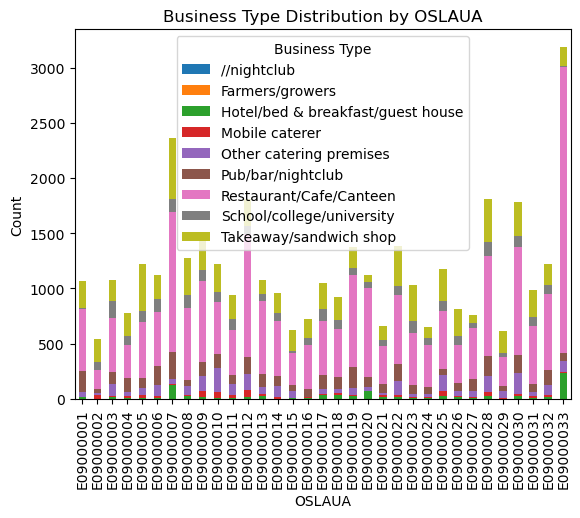

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have the data stored in a DataFrame called 'data'
grouped_data = nonna_merged_data.groupby('oslaua')['Business Type'].value_counts().unstack()

plt.figure(figsize=(15, 5)) 
# Plotting the grouped data
grouped_data.plot(kind='bar', stacked=True)

# Setting the plot labels and title
plt.xlabel('OSLAUA')
plt.ylabel('Count')
plt.title('Business Type Distribution by OSLAUA')
plt.savefig('osla_regions_mapz_population_density.png')
# Display the plot
plt.show()

### Plotting restaurants across London

In [113]:
# import folium
# from folium.plugins import MarkerCluster

# # Create a base map centered around London
# london_map = folium.Map(location=[51.5074, -0.1278], zoom_start=10)

# # Create a MarkerCluster layer
# marker_cluster = MarkerCluster().add_to(london_map)

# # Iterate over the dataset and add markers for each location
# for index, row in nonna_merged_data.iterrows():
#     oslaua = row['oslaua']
#     latitude = row['Latitude']
#     longitude = row['Longitude']
    
#     tooltip = f"OSLAUA: {oslaua}"
    
#     folium.Marker(
#         location=[latitude, longitude],
#         tooltip=tooltip,
#         icon=folium.Icon(color='blue')
#     ).add_to(marker_cluster)

# # Display the map
# london_map


#### Ploting rating values for the restaurants 

In [29]:
gdp_restaurant = gpd.GeoDataFrame(nonna_merged_data, geometry=gpd.points_from_xy(nonna_merged_data.Longitude, nonna_merged_data.Latitude, crs='epsg:27700'))
print(gdp_restaurant.geometry.crs)
print(gdp_restaurant.total_bounds)
hyg_with_rating = gdp_restaurant.copy()
hyg_with_rating['Rating Value'] = hyg_with_rating['Rating Value'].astype('int32')  # convert rating type to int
print(hyg_with_rating['Rating Value'].dtypes)

epsg:27700
[-0.4934373 51.2194365  0.298872  51.684863 ]
int32


<Axes: >

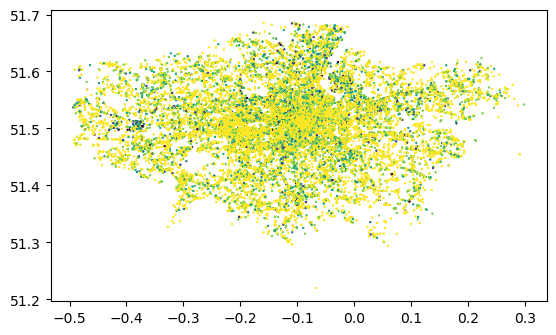

In [31]:
hyg_with_rating.plot(column='Rating Value',   marker='*', markersize=0.5)

In [32]:
# Group the data by "Predicted Cuisine Type" and count occurrences
cuisine_counts = nonna_merged_data['Predicted Cuisine Type'].value_counts()

# Select the top 30 cuisines and their corresponding occurrence counts
top_30_cuisines = cuisine_counts.head(50)

#### Loading population data 

In [33]:
london_population = pd.read_csv("London Population /Local Authority Code wise data.csv")
london_population = london_population.drop(['Number of Employees','Number of Unemployees'], axis = 1)
analysis_data = pd.merge(nonna_merged_data,london_population, on = 'oslaua', how = 'outer' )
drop_columns = ['pcds','Lower tier local authorities Code','Unnamed: 0_y']
analysis_data.drop(columns = drop_columns, inplace = True)

In [34]:
analysis_data.columns

Index(['Unnamed: 0_x', 'Business Name ', 'Business Type', 'Rating Value',
       'Hygiene', 'processed_text', 'Predicted Cuisine Type', 'Latitude',
       'Longitude', 'Address ', 'Post Code', 'oslaua',
       'Lower tier local authorities', 'Mean Salary ', 'population', 'lat',
       'long'],
      dtype='object')

## Analysis

### Correlation

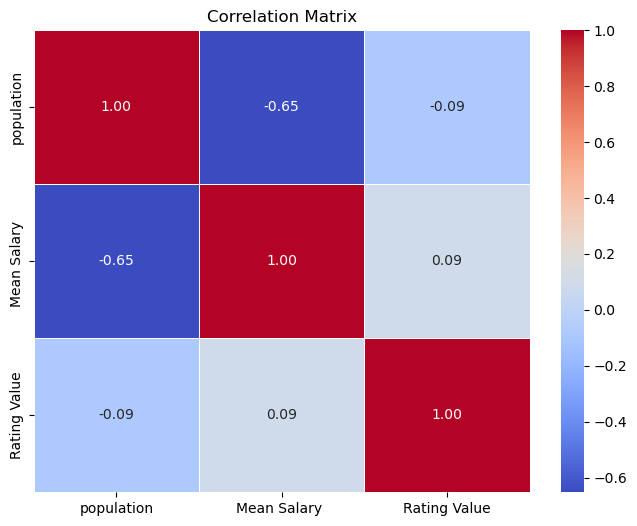

In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have the 'analysis_data' dataset loaded in a DataFrame named 'data'

# Calculate the correlation matrix
correlation_matrix = analysis_data[['population', 'Mean Salary ', 'Rating Value']].corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


#### Analysis of each OSLAUA region 

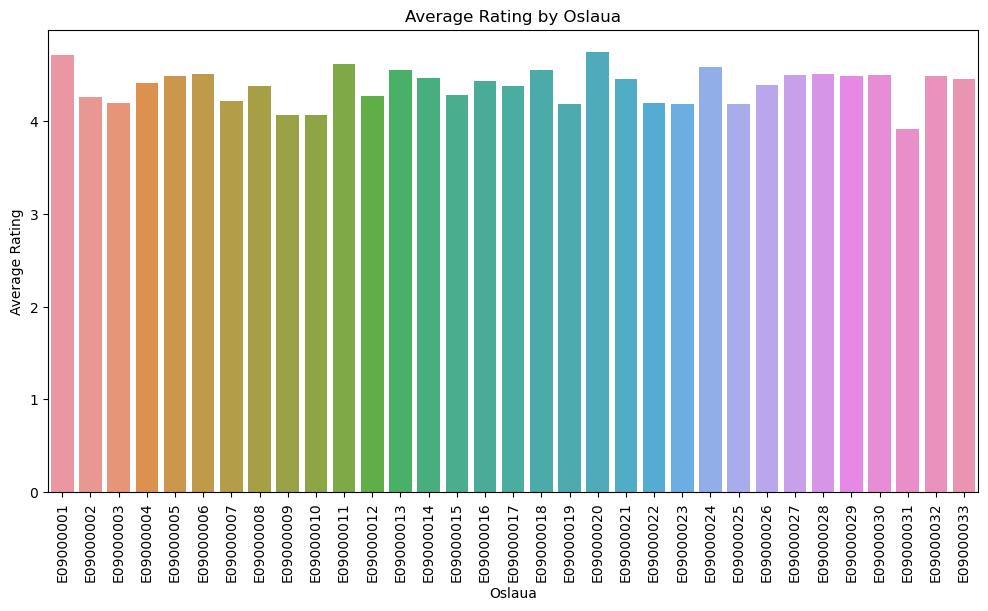

In [37]:
# Convert 'Rating Value' column to numeric type (float)
analysis_data['Rating Value'] = pd.to_numeric(analysis_data['Rating Value'], errors='coerce')

# Group the data by Oslaua and calculate the average rating for each group
average_rating_by_oslaua = analysis_data.groupby('oslaua')['Rating Value'].mean().reset_index()

# Sort the data by average rating in descending order
average_rating_by_oslaua = average_rating_by_oslaua.sort_values(by='Rating Value', ascending=False)
average_rating_by_oslaua = average_rating_by_oslaua.sort_values('oslaua')


# Create a bar plot to visualize the average rating for each Oslaua
plt.figure(figsize=(12, 6))
sns.barplot(data=average_rating_by_oslaua, x='oslaua', y='Rating Value')
plt.title('Average Rating by Oslaua')
plt.xlabel('Oslaua')
plt.ylabel('Average Rating')
plt.xticks(rotation=90)
plt.show()

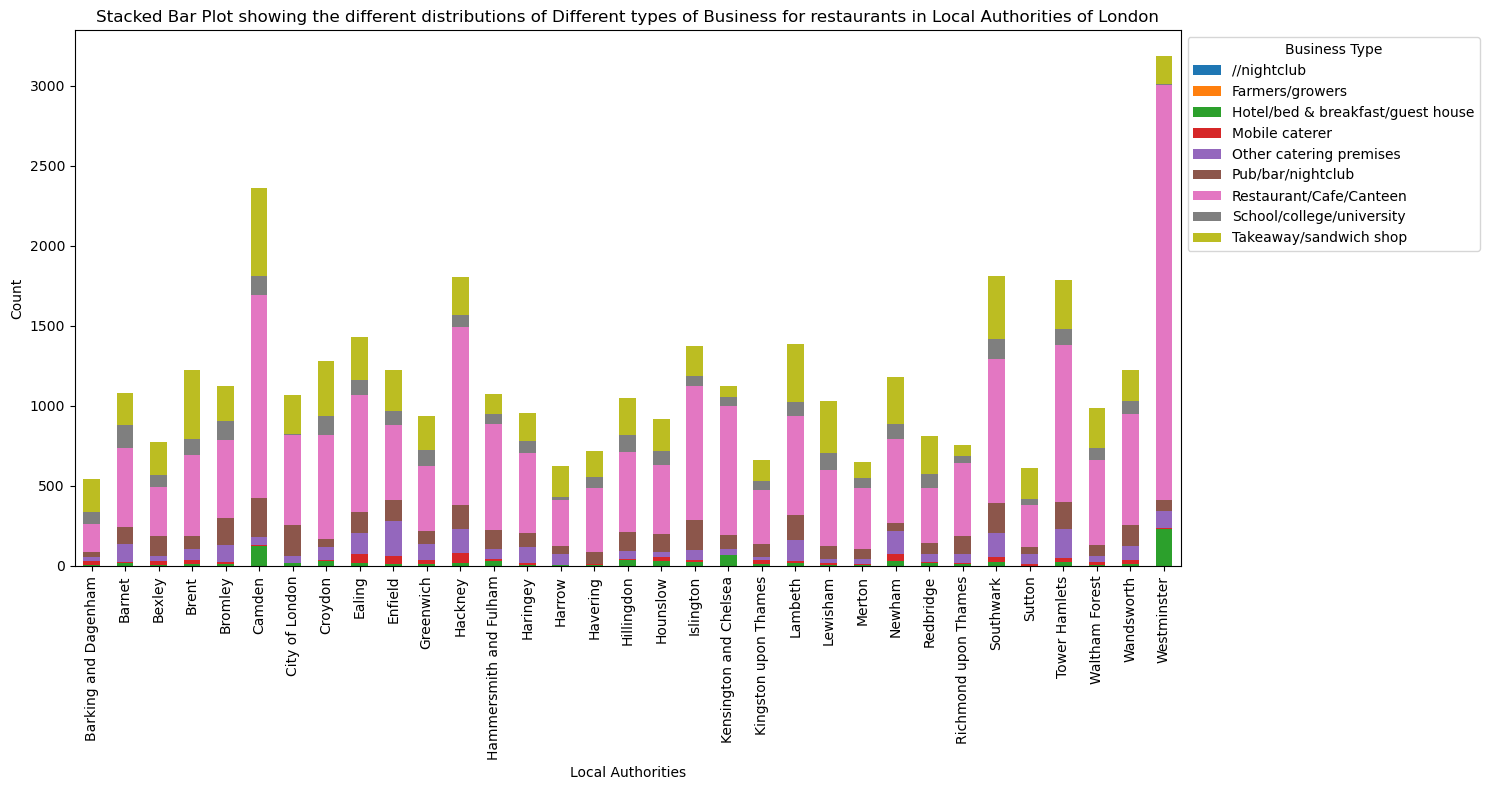

In [38]:


grouped_data = analysis_data.groupby(['Lower tier local authorities'])['Business Type'].value_counts().unstack(1)
# Define a custom color map with 9 different colors for 9 business types
color_map = {
    '//nightclub': 'tab:blue',
    'Farmers/growers': 'tab:orange',
    'Hotel/bed & breakfast/guest house': 'tab:green',
    'Mobile caterer': 'tab:red',
    'Other catering premises': 'tab:purple',
    'Pub/bar/nightclub': 'tab:brown',
    'Restaurant/Cafe/Canteen': 'tab:pink',
    'School/college/university': 'tab:gray',
    'Takeaway/sandwich shop': 'tab:olive'
}

title = 'Stacked Bar Plot showing the different distributions of Different types of Business for restaurants in Local Authorities of London'

# Plot the stacked bar plot with different colors for each business type
ax = grouped_data.plot.bar(stacked=True, color=[color_map[col] for col in grouped_data.columns], title=title, figsize=(15, 8))

# Add labels to the plot
plt.xlabel('Local Authorities')
plt.ylabel('Count')
plt.legend(title='Business Type', bbox_to_anchor=(1, 1))

plt.savefig('osla_regions_mapz_business_type.png')

plt.tight_layout()
plt.show()

### Visualization of how restaurants are located based on their rating 

<Axes: title={'center': 'Stacked Bar Plot showing the different distributions of Local Athorities relating to hygiene ratings in the UK '}, xlabel='Lower tier local authorities'>

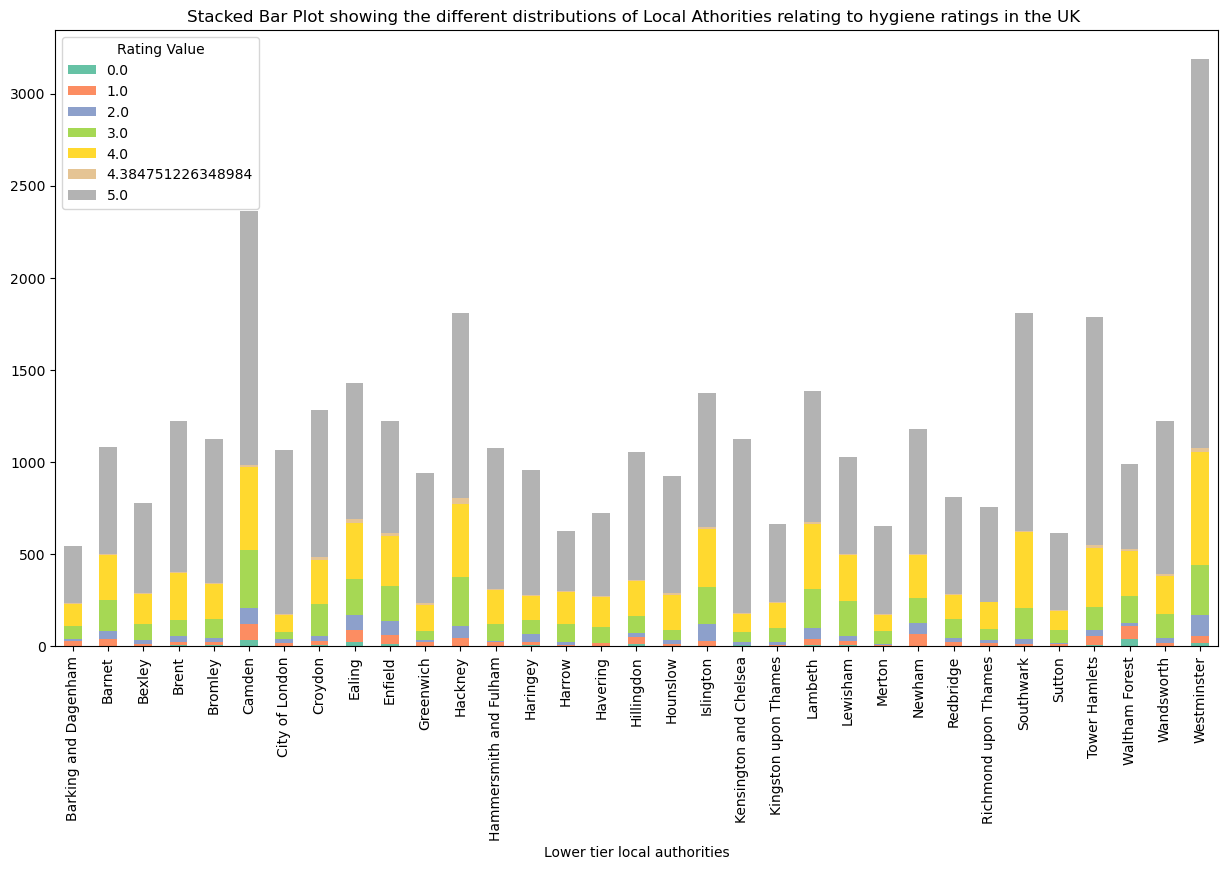

In [39]:
newFrame = analysis_data.groupby(['Lower tier local authorities'])['Rating Value'].value_counts().unstack(1)
title = 'Stacked Bar Plot showing the different distributions of Local Athorities relating to hygiene ratings in the UK '

newFrame.plot.bar(stacked=True,  colormap ='Set2', title=title,figsize=(15,8))

In [40]:
import pandas as pd

# Assuming your data is stored in the 'analysis_data' DataFrame

# Convert 'Rating Value' column to numeric (if it contains any non-numeric values, they will be converted to NaN)
analysis_data['Rating Value'] = pd.to_numeric(analysis_data['Rating Value'], errors='coerce')

# Group by the specified columns and calculate the mean of 'Rating Value'
average_ratings = analysis_data.groupby(['oslaua','lat','long','Lower tier local authorities','Mean Salary '])['Rating Value'].mean().reset_index()




### Finding the center locations for OSLAUA

In [41]:
# Assuming you have the 'data' DataFrame loaded

# Group by OSLAUA and calculate the mean latitude and longitude for each group
center_locations = analysis_data.groupby('oslaua')[['Latitude', 'Longitude']].mean().reset_index()

# Rename the columns for clarity
center_locations.rename(columns={'Latitude': 'CenterLatitude', 'Longitude': 'CenterLongitude'}, inplace=True)



In [42]:
oslaua_average_rating = pd.merge(average_ratings,center_locations, on = 'oslaua', how = 'inner')
oslaua_average_rating.drop(columns = ['lat','long'], inplace = True)

In [44]:
oslaua_average_rating

,oslaua,Lower tier local authorities,Mean Salary,Rating Value,CenterLatitude,CenterLongitude
0,E09000001,City of London,94475.00000,4.716265,51.514646,-0.090344
1,E09000002,Barking and Dagenham,40064.00000,4.257502,51.547158,0.123973
2,E09000003,Barnet,54376.96682,4.197182,51.608302,-0.204421
3,E09000004,Bexley,45518.49315,4.417767,51.457631,0.134516
4,E09000005,Brent,43597.05202,4.492598,51.554119,-0.258364
5,E09000006,Bromley,52578.32487,4.505310,51.393071,0.025351
6,E09000007,Camden,67596.24060,4.215424,51.533683,-0.141707
7,E09000008,Croydon,46493.00000,4.383895,51.373840,-0.093970
8,E09000009,Ealing,47412.50000,4.072077,51.516268,-0.317113
9,E09000010,Enfield,45572.13115,4.068105,51.640694,-0.080040


In [53]:
pop_merge = pd.merge(pop_den ,oslaua_average_rating, on = 'Lower tier local authorities', how = 'inner')

### Plotting geographic information with respect to OSLAUA

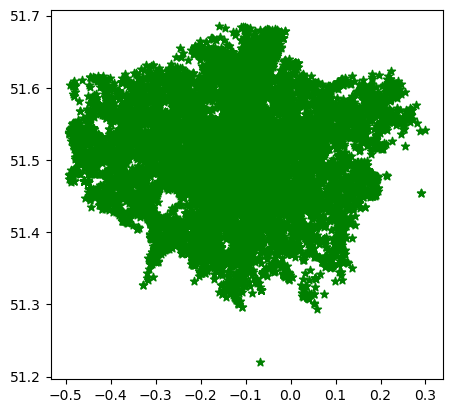

In [45]:
gdf = gpd.GeoDataFrame(analysis_data, geometry= gpd.points_from_xy(analysis_data.Longitude, analysis_data.Latitude))
gdf.crs = "EPSG:4326" #Adding crs information to geodataframe
gdf.plot(marker = '*', color = 'green') #Plotting the geodataframe
plt.rcParams['figure.figsize'] = [10, 10] 

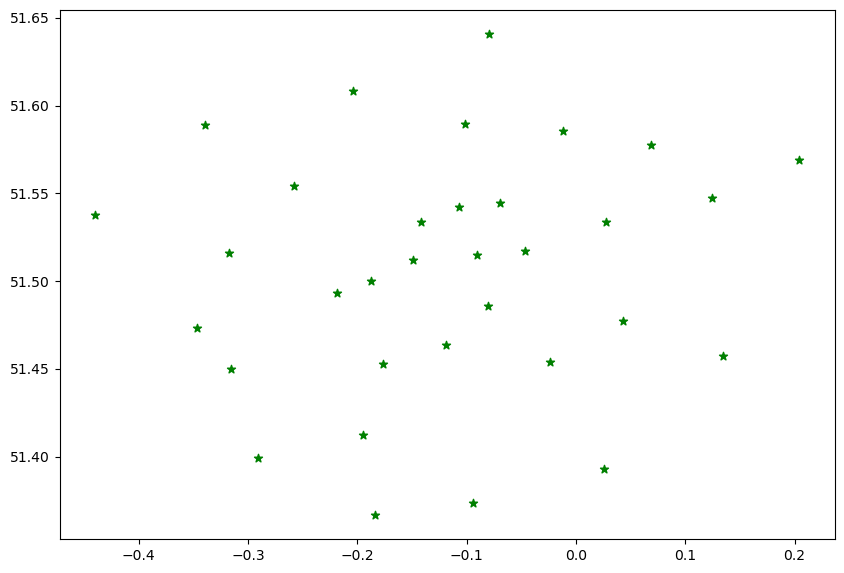

In [46]:
gdf_oslaua = gpd.GeoDataFrame(oslaua_average_rating, geometry= gpd.points_from_xy(oslaua_average_rating.CenterLongitude, oslaua_average_rating.CenterLatitude))
gdf_oslaua.crs = "EPSG:4326" #Adding crs information to geodataframe
gdf_oslaua.plot(marker = '*', color = 'green') #Plotting the geodataframe
plt.rcParams['figure.figsize'] = [10, 10] 

/var/folders/j_/yy54qztd2qv_yhxvrrgcbd1c0000gn/T/ipykernel_90477/2488275631.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


<Axes: >

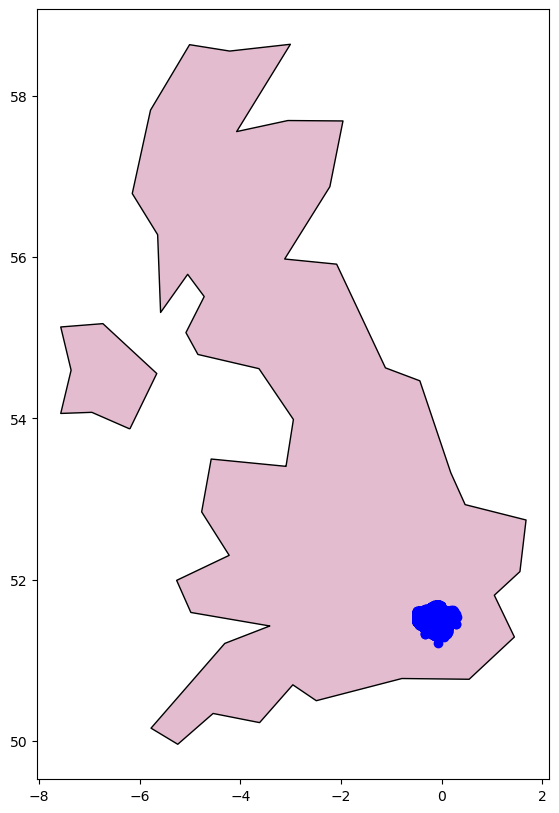

In [47]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))  
uk = world[world['name'] == 'United Kingdom']

ax = uk.plot(color ='#e3bccf', edgecolor = 'black')
plt.rcParams['figure.figsize'] = [10, 10] 

# for x, y, label in zip(uk.geometry.representative_point().x, uk.geometry.representative_point().y, africa_gdf.name):
#     ax.annotate(label, xy=(x, y))
    
gdf.plot(ax=ax, color = 'blue')

In [48]:
gpd.options.use_pygeos = True  # optional, for improved performance
gpd.options._config['SHAPE_RESTORE_SHX'] = 'YES'

/Users/kruthikaramesh/opt/anaconda3/envs/newenv/lib/python3.11/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.2-CAPI-1.17.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [112]:
london_shapefile = gpd.read_file("London Population /London_Borough_Excluding_MHW.shp")
london_shapefile['geometry'].to_crs(epsg=4326)#, allow_override=True)
london_new = london_shapefile.to_crs(epsg=4326)#, allow_override=True)
# ax = gdf_oslaua.plot(alpha=0.1, color='green')
# london_new.plot(ax=ax, color = '#C6A619')

### Plotting Population density

In [51]:
gdf_oslaua.columns

Index(['oslaua', 'Lower tier local authorities', 'Mean Salary ',
       'Rating Value', 'CenterLatitude', 'CenterLongitude', 'geometry'],
      dtype='object')

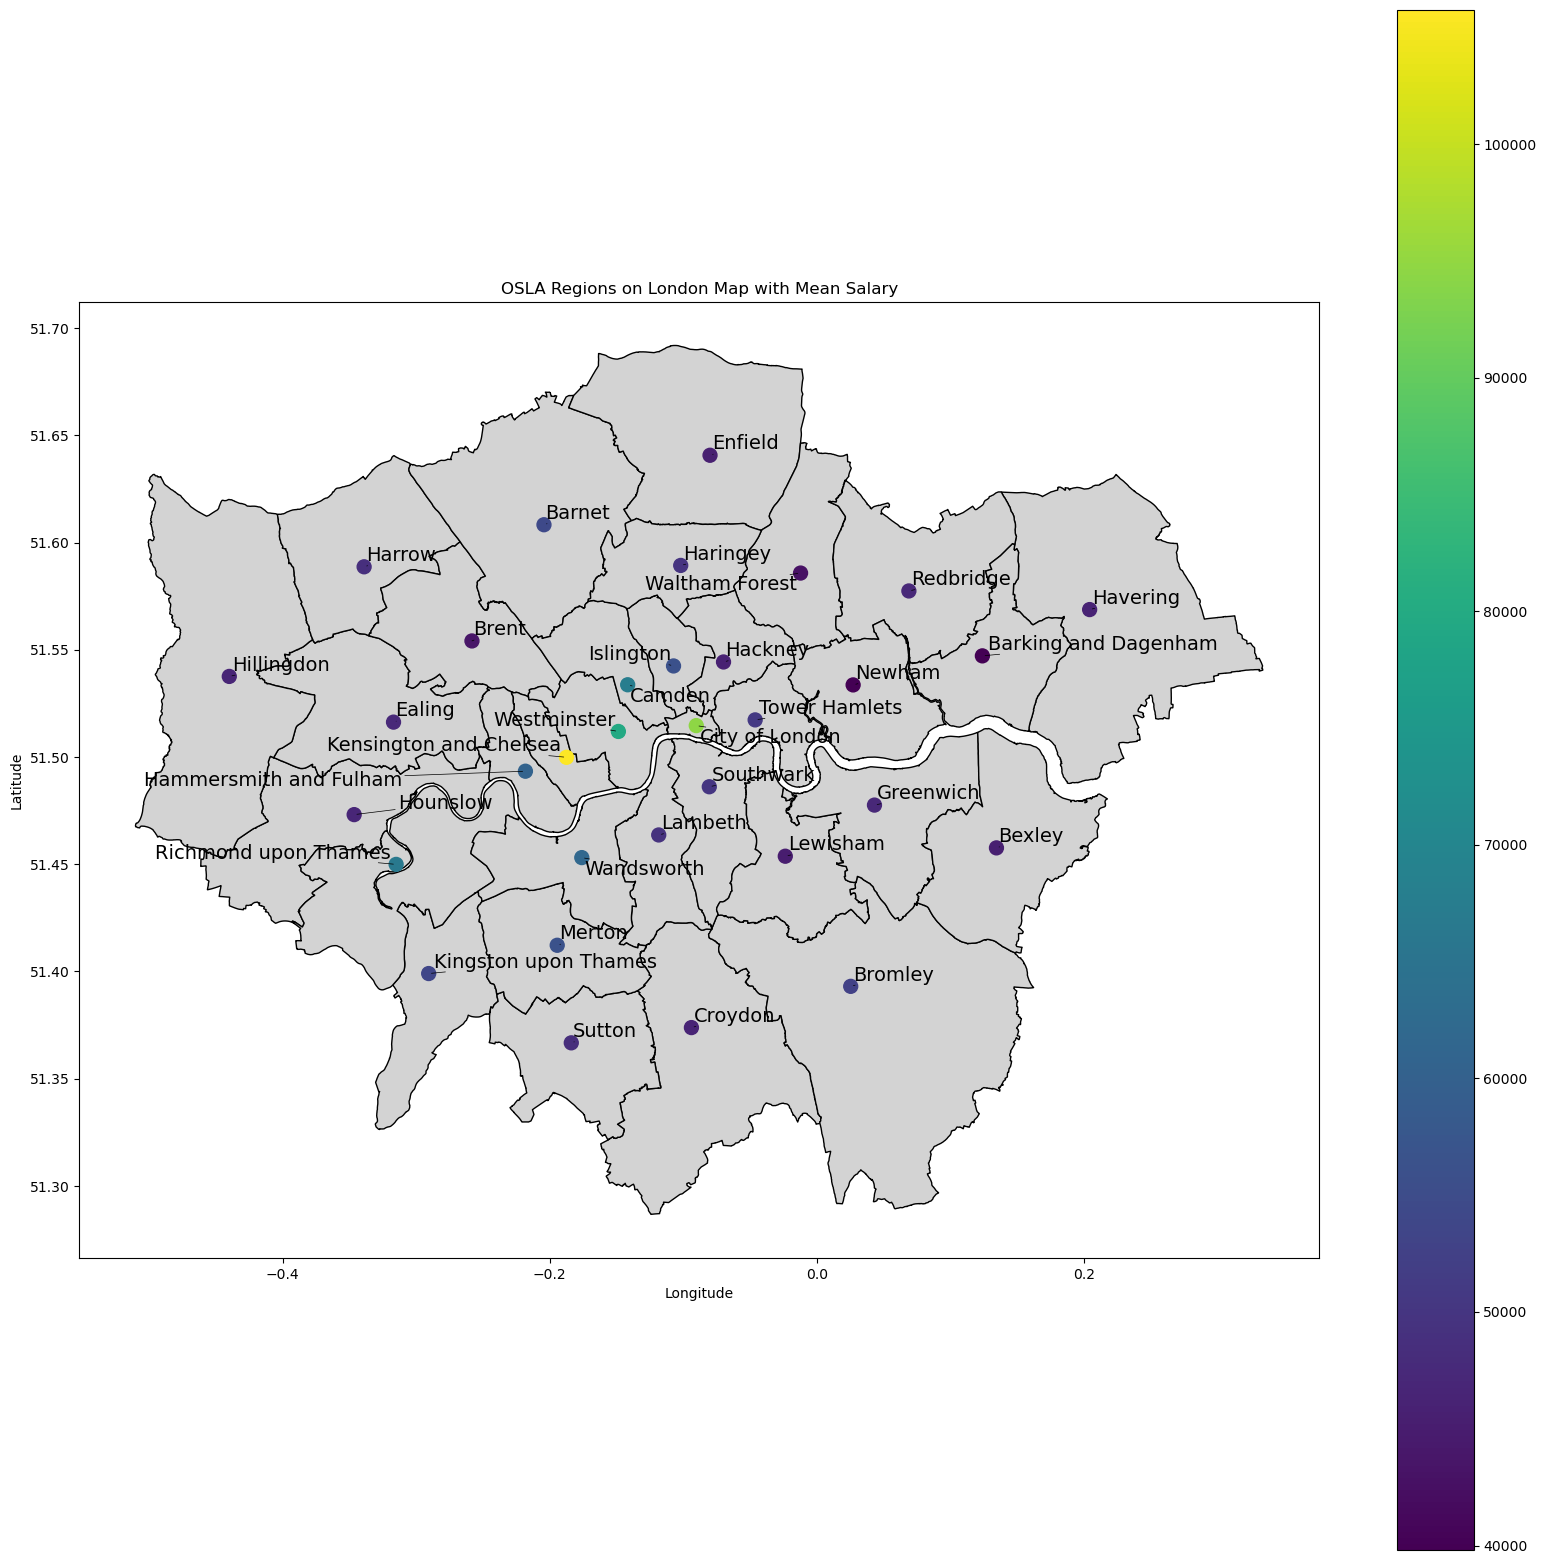

In [56]:
import matplotlib.pyplot as plt
from adjustText import adjust_text  # Import the adjust_text function

# Assuming you have the 'london_new' and 'gdf_oslaua' DataFrames loaded

fig, ax = plt.subplots(figsize=(20, 20))

# Plot the entire London region with a single color
london_new.plot(ax=ax, color='lightgrey', edgecolor='black')

# Plot the OSLA regions on the London map, color-coded by average rating
gdf_oslaua.plot(ax=ax, column='Mean Salary ', cmap='viridis', legend=True, markersize=100)

# Set axis labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('OSLA Regions on London Map with Mean Salary')

# Add labels for Lower tier local authorities and use adjust_text to avoid overlaps
texts = []
for x, y, label in zip(gdf_oslaua['CenterLongitude'], gdf_oslaua['CenterLatitude'], gdf_oslaua['Lower tier local authorities']):
    texts.append(ax.text(x, y, label, fontsize=14, color='black'))

# Use adjust_text to automatically adjust the labels to avoid overlaps
adjust_text(texts, arrowprops=dict(arrowstyle="-", color='black', lw=0.5))

# Save the plot as an image (e.g., PNG format)
plt.savefig('osla_regions_map_Mean_Salary.png')

# Show the plot (optional, you can comment this line if you only want to save the image)
plt.show()


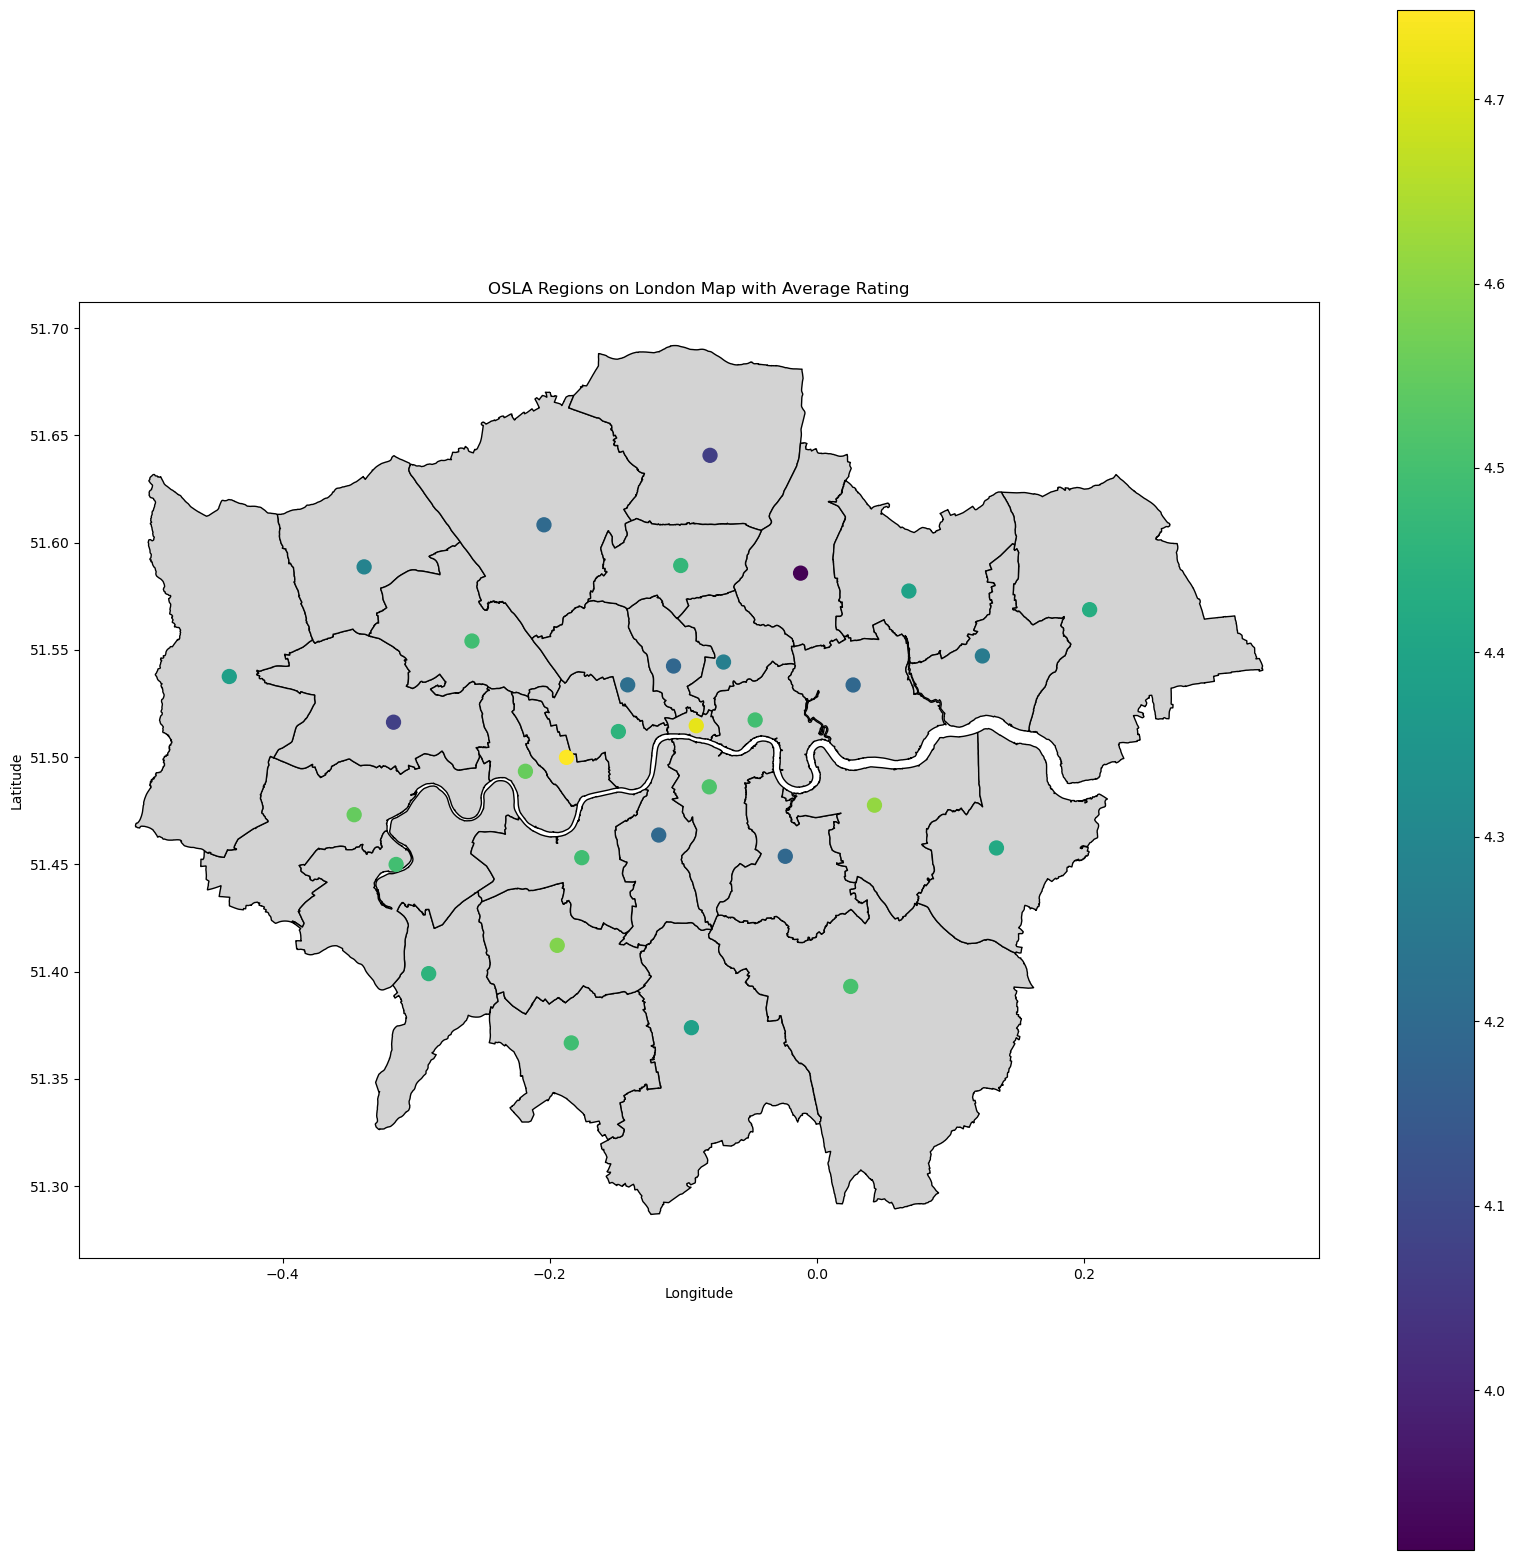

In [57]:
fig, ax = plt.subplots(figsize=(20, 20))
london_new.plot(ax=ax, color='lightgrey', edgecolor='black')

# Plot the OSLA regions on the London map, color-coded by average rating
gdf_oslaua.plot(ax=ax, column='Rating Value', cmap='viridis', legend=True, markersize=100)

# Set axis labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('OSLA Regions on London Map with Average Rating')

plt.show()

### Grouping the data to understand the popularity of cuisines for each OSLAUA region.

In [58]:
# Group the data by 'Lower tier local authorities' and extract the list of predicted cuisine types for each group
cuisine_group = analysis_data.groupby('Lower tier local authorities')['Predicted Cuisine Type'].apply(list).reset_index()

# Rename the columns for clarity
cuisine_group.rename(columns={'Predicted Cuisine Type': 'Cuisine Types'}, inplace=True)


In [59]:
def count_cuisine_words(cuisine_list):
    word_count = {}
    excluded_words = ["and", "new",'traditional','brunch','canteen','caterers','restaurant']  # Add any other words you want to exclude from the count
    
    for cuisine in cuisine_list:
        words = cuisine.lower().split()
        for word in words:
            if word not in excluded_words:
                word_count[word] = word_count.get(word, 0) + 1
    return word_count

# Apply the updated count_cuisine_words function to each row in the dataset
cuisine_group['Cuisine Word Count'] = cuisine_group['Cuisine Types'].apply(count_cuisine_words)

In [60]:
cuisine_group.columns

Index(['Lower tier local authorities', 'Cuisine Types', 'Cuisine Word Count'], dtype='object')

In [61]:
# Sort the word counts in descending order and get the top 10 words
top_10_words = cuisine_group['Cuisine Word Count'].apply(lambda x: sorted(x.items(), key=lambda item: item[1], reverse=True)[:10])


## Demographics 

In [64]:
ethnic_group = pd.read_csv('London Population /Ethinic_groups_london.csv')
ethnic_group['borough'].unique()

array(['City of London', 'Barking and Dagenham', 'Barnet', 'Bexley',
       'Brent', 'Bromley', 'Camden', 'Croydon', 'Ealing', 'Enfield',
       'Greenwich', 'Hackney', 'Hammersmith and Fulham', 'Haringey',
       'Harrow', 'Havering', 'Hillingdon', 'Hounslow', 'Islington',
       'Kensington and Chelsea', 'Kingston upon Thames', 'Lambeth',
       'Lewisham', 'Merton', 'Newham', 'Redbridge',
       'Richmond upon Thames', 'Southwark', 'Sutton', 'Tower Hamlets',
       'Waltham Forest', 'Wandsworth', 'Westminster', 'Inner London',
       'Outer London', 'Greater London'], dtype=object)

In [65]:
ethnic_group.drop(columns = ['2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021','2022','2024', '2025', '2026', '2027', '2028', '2029', '2030',
       '2031', '2032', '2033', '2034', '2035', '2036', '2037', '2038', '2039',
       '2040', '2041', '2042', '2043', '2044', '2045', '2046', '2047', '2048',
       '2049'], inplace = True)

In [66]:
ethnic_group['age'].unique()

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
       '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34',
       '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45',
       '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56',
       '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67',
       '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78',
       '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89',
       '90', 'All ages'], dtype=object)

### Determining the age groups for each location

In [67]:
age_groups = {
    '0-10': range(0, 11),
    '11- 17' : range(11, 18),
    '18-30': range(18, 31),
    '31-50': range(31, 51),
    '51-70': range(51, 71),
    '80 and above': range(80, 120)  # Assuming the maximum age is 119
}

# Function to map age to the corresponding age group
def map_age_to_group(age):
    if age == 'All ages':
        return 'All ages'
    
    try:
        age = int(age)
    except ValueError:
        return 'Unknown'
    
    for group, age_range in age_groups.items():
        if age in age_range:
            return group
    return 'Unknown'

# Apply the mapping function to create a new column 'age_group'
ethnic_group['age_group'] = ethnic_group['age'].map(map_age_to_group)

# Print unique age groups to check the mapping
#print(your_dataframe['age_group'].unique())

# Group by 'age_group' and 'ethnic_group', and sum the '2023' column
result = ethnic_group.groupby(['age_group', 'ethnic_group','borough'])['2023'].sum().reset_index()


In [68]:
result

,age_group,ethnic_group,borough,2023
0,0-10,All persons,Barking and Dagenham,44725
1,0-10,All persons,Barnet,59025
2,0-10,All persons,Bexley,37184
3,0-10,All persons,Brent,51648
4,0-10,All persons,Bromley,49098
...,...,...,...,...
5467,Unknown,White Irish,Sutton,449
5468,Unknown,White Irish,Tower Hamlets,283
5469,Unknown,White Irish,Waltham Forest,433
5470,Unknown,White Irish,Wandsworth,600


In [69]:
result_age = result[result['age_group']!='All ages']
result_age = result_age[result_age['age_group']!='Unknown']
result_age = result_age[result_age['borough'] != 'Greater London']
result_age = result_age[result_age['borough'] != 'Inner London']
result_age = result_age[result_age['borough'] != 'Outer London' ]
result_age = result_age[result_age['borough'] != 'Barking and Dagenham' ]
result_age = result_age[result_age['borough'] != 'Bexley' ]
result_age = result_age[result_age['borough'] != 'City of London' ]
result_age = result_age[result_age['borough'] != 'Greenwich' ]
result_age = result_age[result_age['borough'] != 'Haringey']
result_age = result_age[result_age['borough'] != 'Lewisham' ]
result_age = result_age[result_age['borough'] != 'Newham' ]
result_age = result_age[result_age['borough'] != 'Richmond upon Thames']
result_age = result_age[result_age['borough'] != 'Sutton']

In [71]:
result_age_group = result_age.groupby(['borough','age_group'])['2023'].sum().reset_index()

In [72]:
result_age_group.to_csv("age_group_cuisine.csv")

In [73]:
result_age_group

,borough,age_group,2023
0,Barnet,0-10,146637
1,Barnet,11- 17,93610
2,Barnet,18-30,168108
3,Barnet,31-50,301598
4,Barnet,51-70,207477
...,...,...,...
139,Westminster,11- 17,46287
140,Westminster,18-30,133234
141,Westminster,31-50,205357
142,Westminster,51-70,121602


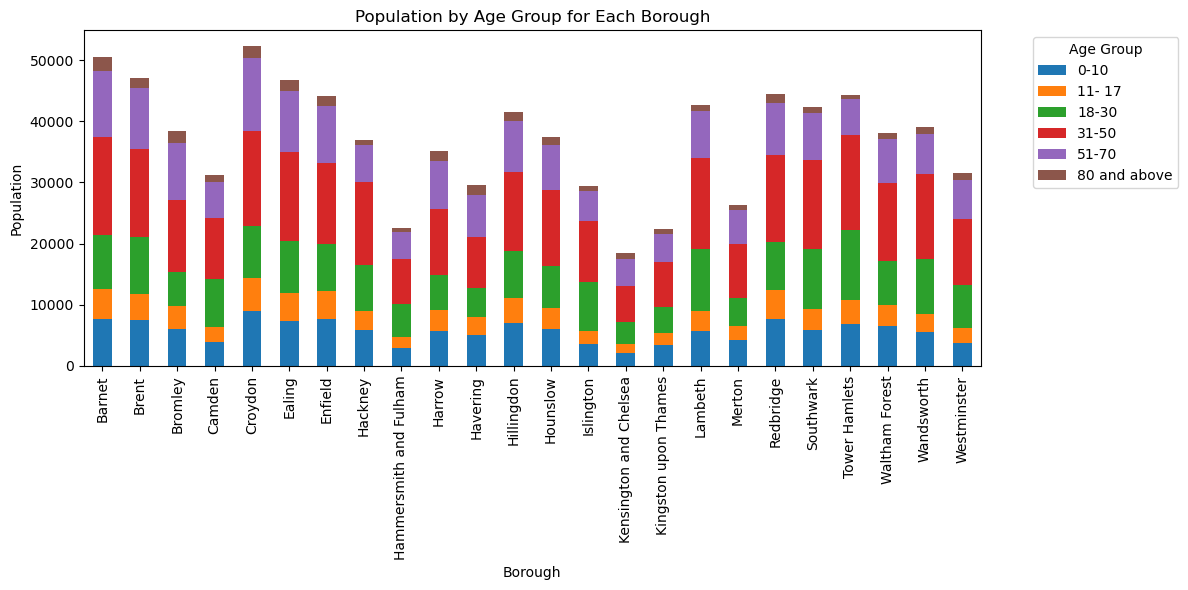

In [74]:
result_age['2023'] = pd.to_numeric(result_age['2023'])

# Pivot the DataFrame to have 'age_group' as columns and 'borough' as rows
pivot_df = result_age.pivot_table(index='borough', columns='age_group', values='2023', fill_value=0)

# Plotting the data as a stacked bar plot
pivot_df.plot(kind='bar', stacked=True, figsize=(12, 6))

# Customizing the plot
plt.xlabel('Borough')
plt.ylabel('Population')
plt.title('Population by Age Group for Each Borough')
plt.legend(title='Age Group', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()

In [75]:
# Group by 'borough' and 'ethnic_group', then calculate the sum of '2023' for each group
grouped_df = ethnic_group.groupby(['borough', 'ethnic_group'])['2023'].sum().reset_index()


In [76]:
grouped_df

,borough,ethnic_group,2023
0,Barking and Dagenham,All persons,461974
1,Barking and Dagenham,Arab,2352
2,Barking and Dagenham,BAME,259386
3,Barking and Dagenham,Bangladeshi,32520
4,Barking and Dagenham,Black African,85521
...,...,...,...
679,Westminster,White & Asian,9562
680,Westminster,White & Black African,4446
681,Westminster,White & Black Caribbean,2964
682,Westminster,White British,144730


In [77]:
filtered_df = grouped_df[grouped_df['ethnic_group'] != 'All persons']
filtered_df = filtered_df[filtered_df['borough'] != 'Greater London']
filtered_df = filtered_df[filtered_df['borough'] != 'Inner London']
filtered_df = filtered_df[filtered_df['borough'] != 'Outer London']

In [78]:
# Convert '2023' to numeric type
filtered_df['2023'] = pd.to_numeric(filtered_df['2023'])


top_5_ethnic_groups = filtered_df.groupby('borough').apply(lambda x: x.nlargest(5, columns='2023')).reset_index(drop=True)
# Reset index to have a clean output
top_5_ethnic_groups.reset_index(drop=True, inplace=True)


In [79]:
top_5_ethnic_groups = top_5_ethnic_groups[top_5_ethnic_groups['ethnic_group']!='BAME']

In [80]:
top_5_ethnic_groups

,borough,ethnic_group,2023
1,Barking and Dagenham,White British,143745
2,Barking and Dagenham,Black African,85521
3,Barking and Dagenham,Other White,56096
4,Barking and Dagenham,Bangladeshi,32520
6,Barnet,White British,316307
...,...,...,...
159,Wandsworth,Black Caribbean,23208
161,Westminster,Other White,159578
162,Westminster,White British,144730
163,Westminster,Arab,49884


In [81]:
grouped_ethnic_groups = top_5_ethnic_groups.groupby('borough').agg({'ethnic_group': list}).reset_index()

In [82]:
grouped_ethnic_groups['borough'].unique()

array(['Barking and Dagenham', 'Barnet', 'Bexley', 'Brent', 'Bromley',
       'Camden', 'City of London', 'Croydon', 'Ealing', 'Enfield',
       'Greenwich', 'Hackney', 'Hammersmith and Fulham', 'Haringey',
       'Harrow', 'Havering', 'Hillingdon', 'Hounslow', 'Islington',
       'Kensington and Chelsea', 'Kingston upon Thames', 'Lambeth',
       'Lewisham', 'Merton', 'Newham', 'Redbridge',
       'Richmond upon Thames', 'Southwark', 'Sutton', 'Tower Hamlets',
       'Waltham Forest', 'Wandsworth', 'Westminster'], dtype=object)

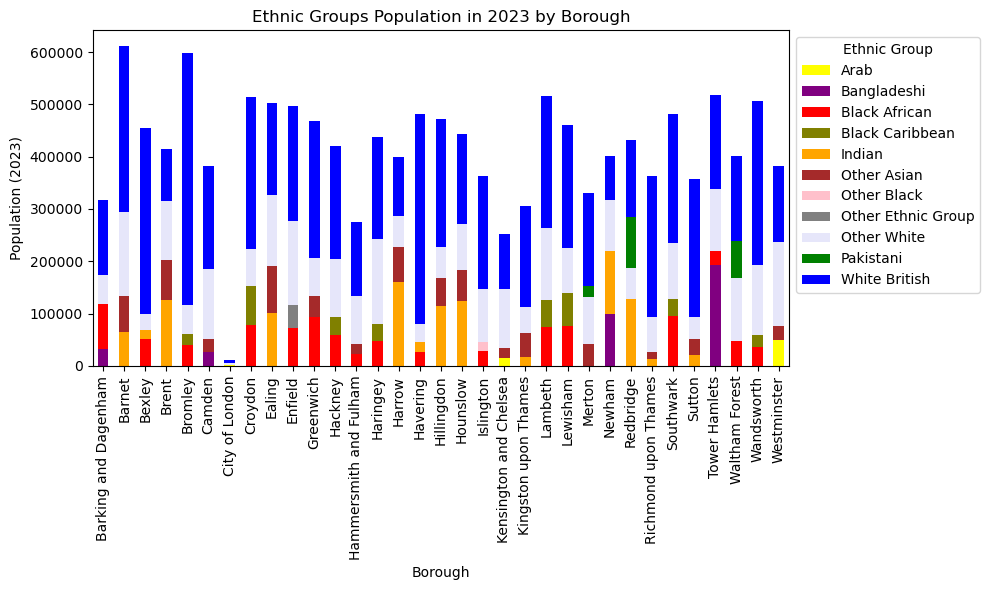

In [84]:
import matplotlib.pyplot as plt
import pandas as pd

# Assume you have the DataFrame 'top_5_ethnic_groups' with the data

# Define custom colors for ethnic groups
colors = {
    'Arab':'yellow',
    'Other Asian': 'brown',
    'Other Black' : 'pink',
    'Other Ethnic Group': 'grey',
    'Other White': 'lavender',
    'Black Caribbean' : 'olive',
    'Pakistani' : 'light blue',
    'White British': 'blue',
    'Indian': 'orange',
    'Pakistani': 'green',
    'Black African': 'red',
    'Bangladeshi': 'purple'
}

# Pivot the DataFrame
pivot_df = top_5_ethnic_groups.pivot(index='borough', columns='ethnic_group', values='2023')

# Plot the stacked bar graph using custom colors
ax = pivot_df.plot(kind='bar', stacked=True, figsize=(10, 6), color=[colors[col] for col in pivot_df.columns])
plt.xlabel('Borough')
plt.ylabel('Population (2023)')
plt.title('Ethnic Groups Population in 2023 by Borough')
plt.legend(title='Ethnic Group', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()


In [89]:
# Calculate the total population in 2023
total_population = grouped_df['2023'].sum()

# Calculate the percentage for each ethnic group
grouped_df['Percentage'] = (grouped_df['2023'] / total_population) * 100

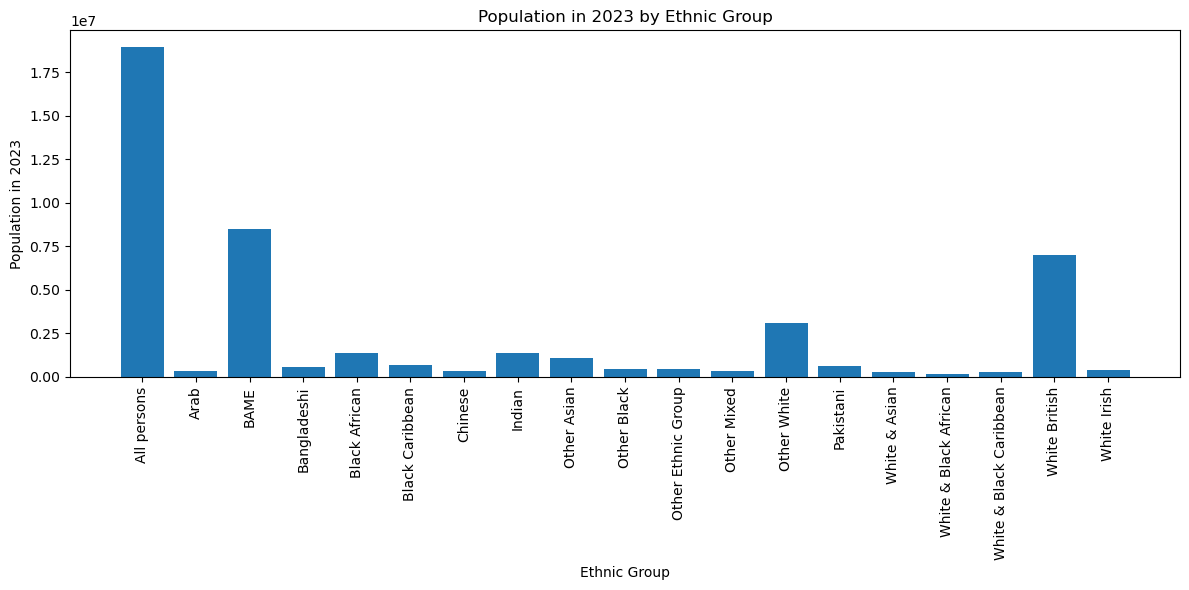

In [92]:
plt.figure(figsize=(12, 6))
plt.bar(grouped_df['ethnic_group'], grouped_df['2023'])
plt.xticks(rotation=90)
plt.xlabel('Ethnic Group')
plt.ylabel('Population in 2023')
plt.title('Population in 2023 by Ethnic Group')
plt.tight_layout()
plt.show()

In [93]:
user_data = pd.read_csv('London Population /london_postcodes-ons-postcodes-directory-feb22.csv')
user_data = user_data[['pcds','oslaua','oa11','lat','long']]
user_data = user_data.dropna(subset = ['lat','long'])

In [94]:
london_population = pd.read_csv("London Population /Local Authority Code wise data.csv")
london_population = london_population.drop(['Number of Employees','Number of Unemployees'], axis = 1)

In [95]:
user_data_pop = pd.merge(user_data,london_population, left_on = 'oslaua', right_on = 'Lower tier local authorities Code', how = 'outer')
user_data = user_data_pop.dropna()

In [97]:
candidate_location = pd.read_csv("London Population /Candidate_location.csv")

In [98]:
matched_locations = []
for idx, row in candidate_location.iterrows():
    match = user_data[(user_data['lat_x'] == row['Latitude']) & (user_data['long_x'] == row['Longitude'])]['oslaua_y']
    if not match.empty:
        matched_locations.append(match.values[0])
    else:
        matched_locations.append(None)

candidate_location['oslaua'] = matched_locations

In [101]:
cuisine_type = pd.read_csv("London Population /Table for cuisine.csv")
cuisine_type['Borough'].unique()

array(['Camden', 'Southwark', 'Westminster', 'Redbridge', 'Harrow',
       'Croydon', 'Kingston upon Thames', 'Enfield', 'Bromley',
       'Islington', 'Waltham Forest', 'Hammersmith and Fulham',
       'Tower Hamlets ', 'Merton', 'Hackney', 'Ealing',
       'Kensington and Chelsea', 'Barnet', 'Brent', 'Lambeth',
       'Hillingdon', 'Hounslow', 'Havering', 'Wandsworth'], dtype=object)

In [102]:
# Assuming you have a DataFrame called 'cuisine_type' with a column 'Borough'
cuisine_type['Borough'] = cuisine_type['Borough'].replace('Tower Hamlets ', 'Tower Hamlets')

In [104]:
# Group by 'Borough' and find top 5 ethnic groups for each borough
top_5_ethnic_groups = top_5_ethnic_groups.groupby('borough').apply(lambda x: x.nlargest(5, '2023'))

# Reset the index to remove the multi-index
top_5_ethnic_groups.reset_index(drop=True, inplace=True)

# Merge the top 5 ethnic groups with dataset 2 based on the 'Borough' column
result = pd.merge(cuisine_type, top_5_ethnic_groups, left_on='Borough', right_on='borough')

# Drop unnecessary columns and rename columns
result.drop(['borough', 'ethnic_group'], axis=1, inplace=True)
#result.rename(columns={'ethnic_group_x': 'Ethnic Group', '2023': 'Population'}, inplace=True)


In [105]:

# Merge the top 5 ethnic groups with dataset 2 based on the 'Borough' column
result = pd.merge(cuisine_type, grouped_ethnic_groups, left_on='Borough', right_on='borough', how = 'inner')



In [107]:
sorted_dataframe = result.sort_values(by='Index')

In [108]:
sorted_dataframe.drop(columns = ['borough'])

,Unnamed: 0,Index,Borough,Top 5 Cuisine Types,ethnic_group
0,0,1,Camden,"american, indian, asian, bar, mediterranean","[White British, Other White, Other Asian, Bang..."
1,1,2,Camden,"tea, coffee, caterers, asian, bar","[White British, Other White, Other Asian, Bang..."
5,2,3,Southwark,"cafe, bar, european, chicken, sea","[White British, Other White, Black African, Bl..."
6,3,4,Westminster,"italian, bar, mediterranean, european, chicken","[Other White, White British, Arab, Other Asian]"
2,4,5,Camden,"chinese, indian, asian, bar, mediterranean","[White British, Other White, Other Asian, Bang..."
9,5,6,Redbridge,"bars, chinese, indian, bar, mediterranean","[White British, Indian, Pakistani, Other White]"
10,6,7,Harrow,"breakfast, chinese, caterers, asian, bar","[Indian, White British, Other Asian, Other White]"
11,7,8,Croydon,"cafe, pizza, caterers, indian, asian","[White British, Black African, Black Caribbean..."
13,8,9,Kingston upon Thames,"tea, coffee, caterers, mediterranean, european","[White British, Other White, Other Asian, Indian]"
3,9,10,Camden,"indian, asian, bar, mediterranean, european","[White British, Other White, Other Asian, Bang..."


In [109]:
sorted_dataframe.to_csv("Cuisine_ethnical.csv")